<a href="https://colab.research.google.com/github/pavlyukm/ml-cp/blob/main/ML_Course_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
from utils import (
    run_complete_pipeline,
    plot_feature_importance,
    create_results_summary
)

In [3]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [4]:
data = pd.read_excel('Цукровий Буряк.xlsx')
data = data.dropna(subset=['Врожай-\nність'])
data = data.rename(columns={'Врожай-\nність': 'Yield'})

weather_data = pd.read_excel('Погода.xlsx')

# print(data.head())
# print(weather_data.head())

# Data Description

## Dataset Overview
- **Description**: This dataset contains information about sugar beets farming, including sugar yields and associated weather conditions. The goal is to analyze the impact of various factors on sugar yields.

## Dataset Structure
- **Number of Records**: 962
- **Number of Features**: 62
- **File Format**: XLSX

## Feature Description

| Feature Name                | Description                                                                 |
|------------------------------|-----------------------------------------------------------------------------|
| Зведений підрозділ           | Потребує уточнення, швидш за все не важлива для нас змінна                                                     |
| Підрозділ                    | Потребує уточнення, швидш за все не важлива для нас змінна                                                           |
| Урочище                      | Основна ділянка ферми, по якій будується звіт: всі наступні дані стсосуються саме урочища                                           |
| Рік                          | рік збору врожаю                                                    |
| Гібрид 1                     | тип буряка: змінна для word embedding?                                                     |
| Технологія захисту           | Класична або СМАРТ. Слід заенкодити в 1 \ 0                                                |
| Стійкість до нематоди        | пусто = ні = 0, так = 1                                                     |
| Церкоспора                   | -, --, +, ++, або цифри -- потребує уточнення, невідомо як енкодити                                                  |
| Кореневі і/або нематода      | присутній, -, +, ++, --, +н, ++/-н, ++н, -/-, -н, або цифри, потребує уточнення, невідомо як енкодити                                                     |
| Сівозміна з буряком          | 3, 4, більше 4, Більше 4 (Нові площі/облоги), потребує уточнення                                               |
| Примітки                     | швидш за все неважлива змінна, досить спарс, але можна уточнити                                                    |
| Попередник                   | яка культура росла перед буряком. Також можна зробити ебмеддінг?                                                   |
| Згрупований попередник       | потрібно уточнити, швидш за все неважливо                                                  |
| Площа                        | float, гектари                                                  |
| Осн. Культура                | Цукровий буряк                                                    |
| Період грунтообробітку       | зима або осінь, заенкодити 1-0                                                     |
| К-ть основних обробітків      | 1 слід або 2 сліди: 1 \ 2                                                   |
| Тип грунту                   | тут не робоча VLOOKUP функція, потрібно попросити ці дані додатково                                                 |
| N                            | int: припускаю це мг \ га                                                     |
| P2O5                         | int: припускаю це мг \ га                                                     |
| K2O                          | int: припускаю це мг \ га                                                  |
| Na2O                         | int: припускаю це мг \ га                                                    |
| S                            | int: припускаю це мг \ га                                                    |
| Безводний Аміак              | порожньо = 0 або безводний = 1                                                  |
| Сидерати                     | порожньо = 0 так = 1                                                   |
| Органіка                     | ні \ так = 0 1                                                  |
| Вид органіки                 | ВРХ, СВИ, КУР, КОМП, багато порожнього = енкодити                                                  |
| Норма                        | int: невідомо, чого це стосується                                                |
| Негативні чинники (Враховувати)| Гнилі, не рахуємо, слабкі сходи або порожньо = енкодити                                                |
| Дата посіву                  | дата посіву у різному форматі                                                 |
| Середня дата посіву          | 1-12 місяць посіву                                                  |
| Діапазон посіву              | string: крайня дата посіву                                                   |
| Дата появи сходів            | date                                               |
| Дата змикання міжряддя       | дата зикання в різному форматі, швидш за все важлива змінна                                              |
| Дата збирання                | date: дата збирання врожаю                                                  |
| Густота на 30 день, тис.     | float: потрібно уточнити, що це означає                                              |
| Норма висіву                 | 120 або порожньо: потрібно уточнити                                                   |
| Густота збирання             | float: густота на момент збору? Потрібно уточнити                                                   |
| Польова схожість             | 0-100%, густота збирання \ норма висіву                                      |
| Тривалість сходів            | int: дата появи сходів - дата посіву                                                   |
| Днів до змикання міжряддя    | int: дата змикання міжряддя - дата появи сходів                                                  |
| Тривалість активної вегетації| float: дата збирання - дата змикання                                     |
| Група активної вегет         |string: часові періоди в днях, заенкодити                                                 |
| Період сходів                | string: часові періоди в днях, заенкодити                                                |
| Період вегетації             | date: дата збирання - дата появи сходів                                                 |
| Група періоду вегетації      | string: часові періоди в днях, заенкодити                                                       |
| Врожай-                 | float                                                    |
| Базова врожайність           | float                                                     |
| Відносна врожайність         | float: врожай- \ базова врожайність                                                  |
| Цукристість                  | float                                               |
| Вал Цукру                    | float: Вихід Цукру з га  \ Площа                                               |
| Вихід Цукру з га             | float: цукристіть \ Врожай-                                                 |
| Прогноз Цукру                | float: =0.0427*тривалість активної вегетації + 6.9375                                                     |
| Відхилення по цукру          | float, % : Вихід Цукру з га \ Прогноз Цукру - 1                                                     |
| Вал                          | float: Врожай- * Площа                                                 |
| Вал Відносної врожайності    | float: Відносна врожайність * Площа                                             |
| NUE                          | float: Врожай- \  N *1000                                                    |
| Вивезення днів               | int                                                   |
| Меляса                       | int                                                   |
| рН                           | неробочий VLOOKUP, треба уточнити дані                                                   |
| Дефекат                      | 0 = порожньо = ні, 1 = так                                                    |
| Періоди вивезення            | string: часові періоди в днях, заенкодити                                                     |


## Target Variable
- **Name**: yield
- **Type**: Float
- **Description**: Врожай цукрових буряків з 1 гектару у тоннах


# Data Processing Pipeline

Our pipeline includes:
- Data leakage detection and removal
- Weather data integration with yearly aggregations
- Feature engineering (weather interactions, fertilizer ratios, management scores)
- Smart feature selection combining multiple methods
- Anti-overfitting model training

In [5]:
print(weather_data.columns)

Index(['LAT', 'LON', 'YEAR', 'DOY', 'YIELD_YEAR', 'Precipitation',
       'Precipitation_Normalized', 'Efective rainfall', 'Wind Speed',
       'Relative humidity', 'Dew point', 'Temperature_MAX', 'Temperature_MIN',
       'Insolation', 'Temperature', 'Active TEMP', 'Active TEMP TRUE',
       'Active TEMP Corn', 'Active TEMP Corn1', 'DATE', 'MONTH', 'YIELD_YEAR2',
       'Days count'],
      dtype='object')


In [6]:
print(data.columns)

Index(['Зведений підрозділ', 'Підрозділ', 'Урочище', 'Рік', 'Гібрид 1',
       'Технологія\n захисту', 'Стійкість до нематоди', 'Церкоспора',
       'Кореневі і/або нематода', 'Сівозміна з буряком', 'Примітки',
       'Попередник', 'Згрупований попередник', 'Площа', 'Осн. Культура',
       'Період грунтообробітку', 'К-ть основних обробітків', 'Тип грунту', 'N',
       'P2O5', 'K2O', 'Na2O', 'S', 'Безводний Аміак', 'Сидерати', 'Органіка',
       'Вид органіки', 'Норма', 'Негативні чинники (Враховувати)',
       'Дата посіву', 'Середня дата посіву', 'Діапазон посіву',
       'Дата появи сходів', 'Дата змикання міжряддя', 'Дата збирання',
       'Густота на 30 день, тис.', 'Норма висіву', 'Густота збирання',
       'Польова схожість', 'Тривалість сходів', 'Днів до змикання міжряддя',
       'Тривалість активної вегетації', 'Група активної вегет',
       'Період сходів', 'Період вегетації', 'Група періоду вегетації', 'Yield',
       'Базова врожайність', 'Відносна врожайність', 'Цукристіст

In [5]:
label_encoder = LabelEncoder()
data_processed = data.copy()

# Remove obvious problematic columns first
columns_to_drop = ['Згрупований попередник', 'Тип грунту', 'Осн. Культура', 'рН', 'Примітки', 
                   'Зведений підрозділ', 'Підрозділ', 'К-ть основних обробітків', 'Норма']
data_processed = data_processed.drop(columns=columns_to_drop, errors='ignore')

# Process categorical features
categorical_features = ['Урочище', 'Гібрид 1', 'Технологія\n захисту', 'Стійкість до нематоди', 
                       'Церкоспора', 'Кореневі і/або нематода', 'Сівозміна з буряком',
                       'Попередник', 'Період грунтообробітку', 'Безводний Аміак', 'Сидерати', 
                       'Органіка', 'Вид органіки', 'Негативні чинники (Враховувати)', 
                       'Середня дата посіву', 'Діапазон посіву', 'Днів до змикання міжряддя', 
                       'Тривалість активної вегетації', 'Група активної вегет', 'Період сходів', 
                       'Група періоду вегетації', 'Дефекат', 'Періоди вивезення']

for feature in categorical_features:
    if feature in data_processed.columns:
        data_processed[feature] = data_processed[feature].astype(str).fillna('missing')
        data_processed[feature] = label_encoder.fit_transform(data_processed[feature])

In [6]:
# Process date columns
date_columns = ['Дата посіву', 'Дата появи сходів', 'Дата змикання міжряддя', 'Дата збирання', 'Період вегетації']

for feature in date_columns:
    if feature in data_processed.columns:
        data_processed[feature] = pd.to_datetime(data_processed[feature], errors='coerce')
        data_processed[feature + '_year'] = data_processed[feature].dt.year
        data_processed[feature + '_month'] = data_processed[feature].dt.month
        data_processed[feature + '_day'] = data_processed[feature].dt.day
        data_processed[feature + '_dayofweek'] = data_processed[feature].dt.dayofweek
        data_processed = data_processed.drop(feature, axis=1)

print(f"Processed data shape: {data_processed.shape}")

Processed data shape: (909, 68)


# Main Pipeline

- Data leakage analysis and removal
- Weather dataset integration
- Feature engineering
- Multi-method feature selection
- XGBoost model optimization

In [7]:
models, results, importance_df, processed_data = run_complete_pipeline(data_processed, weather_data)

🚀 RUNNING COMPLETE PIPELINE
Cleaning Excel error values...
Found 776 Excel error values
Replaced Excel errors with NaN
Cleaning Excel error values...
Cleaned target: 909 → 832 samples
After removing leakage: (832, 48)
=== Weather Data Integration ===
Creating weather features...
Created 42 weather features
Merged data shape: (832, 91)
=== Feature Engineering ===
Feature engineering complete. Shape: (832, 92)
Final data cleaning for modeling...
Final dataset for modeling: 832 samples, 91 features
Scaled 44 weather features
=== Selecting 35 features ===
Selected 35 features, 22 are weather-related
=== Training Models ===
Conservative: R²=0.463, RMSE=8.59, Overfitting=4.25
Balanced: R²=0.647, RMSE=6.96, Overfitting=6.34
Performance: R²=0.688, RMSE=6.55, Overfitting=6.95


In [28]:
create_results_summary(results, importance_df)


🏆 FINAL RESULTS SUMMARY
🏆 Best Model: Performance
📊 R²: 0.688
📊 RMSE: 6.55
📊 Overfitting: 6.95

🔝 TOP 10 FEATURES:
   🌤️ weather_Precipitation_mean: 0.284
   🌤️ weather_Precipitation_sum: 0.187
   🌱 Негативні чинники (Враховувати): 0.148
   🌤️ weather_Efective rainfall_mean: 0.101
   🌤️ weather_Relative humidity_min: 0.032
   🌤️ weather_Insolation_mean: 0.019
   🌤️ weather_Temperature_std: 0.018
   🌤️ growing_Insolation_sum: 0.016
   🌱 Період сходів: 0.013
   🌱 Група активної вегет: 0.013

🌤️ Weather features in top 10: 7


# Results Analysis and Visualization

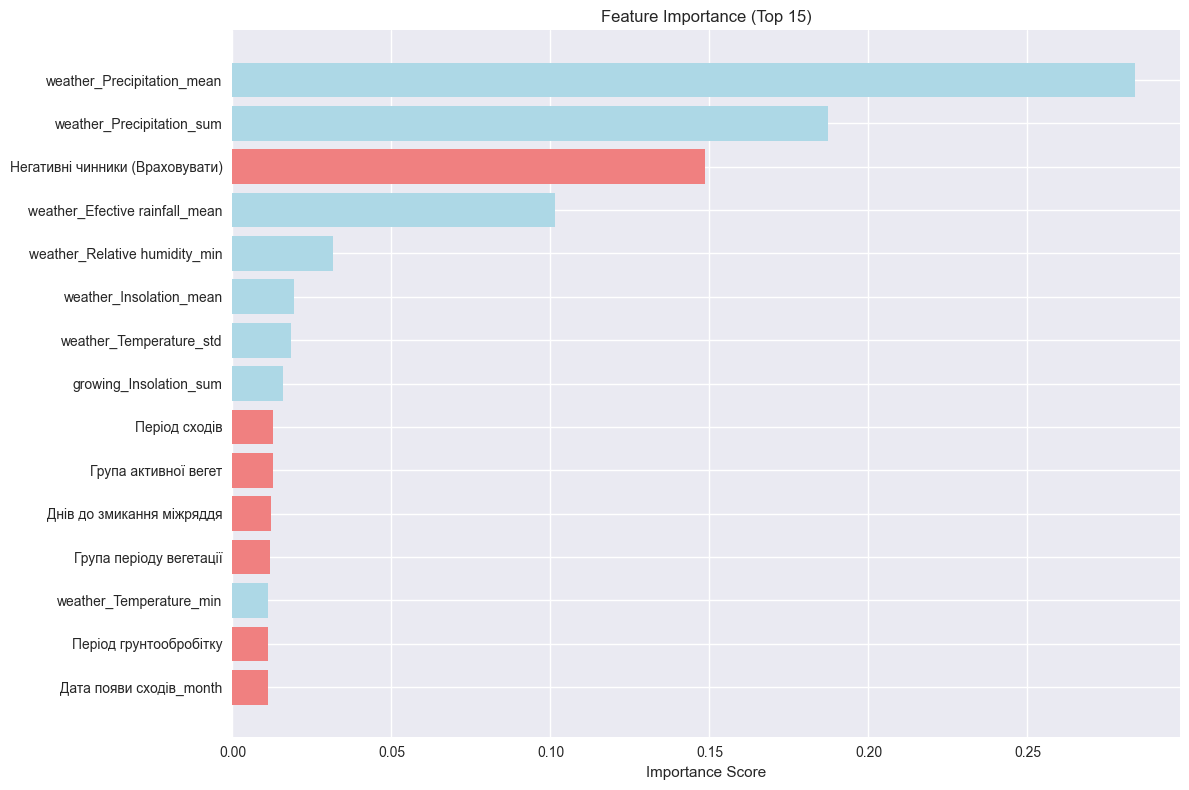

In [27]:
plot_feature_importance(importance_df, top_n=15)

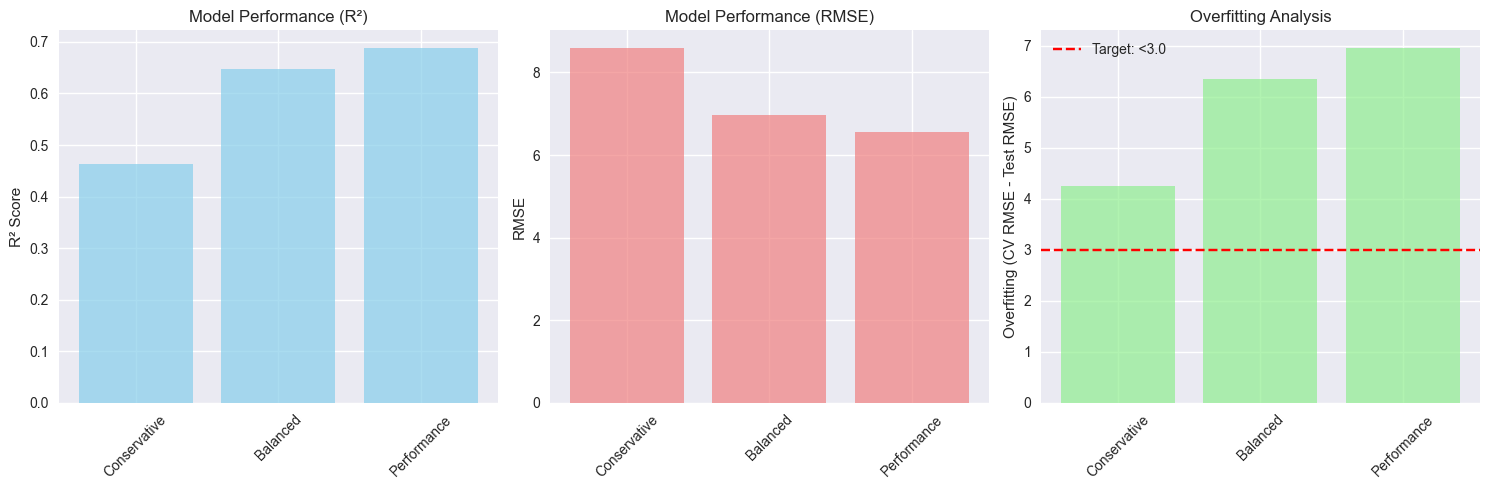

In [26]:
plt.figure(figsize=(15, 5))

# Plot 1: R² comparison
models = list(results.keys())
r2_scores = [results[model]['test_r2'] for model in models]

plt.subplot(1, 3, 1)
plt.bar(models, r2_scores, color='skyblue', alpha=0.7)
plt.ylabel('R² Score')
plt.title('Model Performance (R²)')
plt.xticks(rotation=45)

# Plot 2: RMSE comparison
rmse_scores = [results[model]['test_rmse'] for model in models]

plt.subplot(1, 3, 2)
plt.bar(models, rmse_scores, color='lightcoral', alpha=0.7)
plt.ylabel('RMSE')
plt.title('Model Performance (RMSE)')
plt.xticks(rotation=45)

# Plot 3: Overfitting comparison
overfitting_scores = [results[model]['overfitting'] for model in models]

plt.subplot(1, 3, 3)
plt.bar(models, overfitting_scores, color='lightgreen', alpha=0.7)
plt.axhline(y=3.0, color='red', linestyle='--', label='Target: <3.0')
plt.ylabel('Overfitting (CV RMSE - Test RMSE)')
plt.title('Overfitting Analysis')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [11]:
# Analyze weather vs non-weather features
weather_features = importance_df[importance_df['Feature'].str.contains('weather_|growing_|critical_|early_|late_')]
other_features = importance_df[~importance_df['Feature'].str.contains('weather_|growing_|critical_|early_|late_')]

weather_importance_total = weather_features['Importance'].sum()
other_importance_total = other_features['Importance'].sum()

print(f"Weather features total importance: {weather_importance_total:.3f} ({weather_importance_total/(weather_importance_total+other_importance_total)*100:.1f}%)")
print(f"Other features total importance: {other_importance_total:.3f} ({other_importance_total/(weather_importance_total+other_importance_total)*100:.1f}%)")

# Top weather features
print(f"\n🌤️ Top 5 Weather Features:")
for i, row in weather_features.head(5).iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.3f}")

# Top non-weather features  
print(f"\n🌱 Top 5 Non-Weather Features:")
for i, row in other_features.head(5).iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.3f}")


Weather features total importance: 0.742 (74.2%)
Other features total importance: 0.258 (25.8%)

🌤️ Top 5 Weather Features:
   weather_Precipitation_mean: 0.284
   weather_Precipitation_sum: 0.187
   weather_Efective rainfall_mean: 0.101
   weather_Relative humidity_min: 0.032
   weather_Insolation_mean: 0.019

🌱 Top 5 Non-Weather Features:
   Негативні чинники (Враховувати): 0.148
   Період сходів: 0.013
   Група активної вегет: 0.013
   Днів до змикання міжряддя: 0.012
   Група періоду вегетації: 0.012


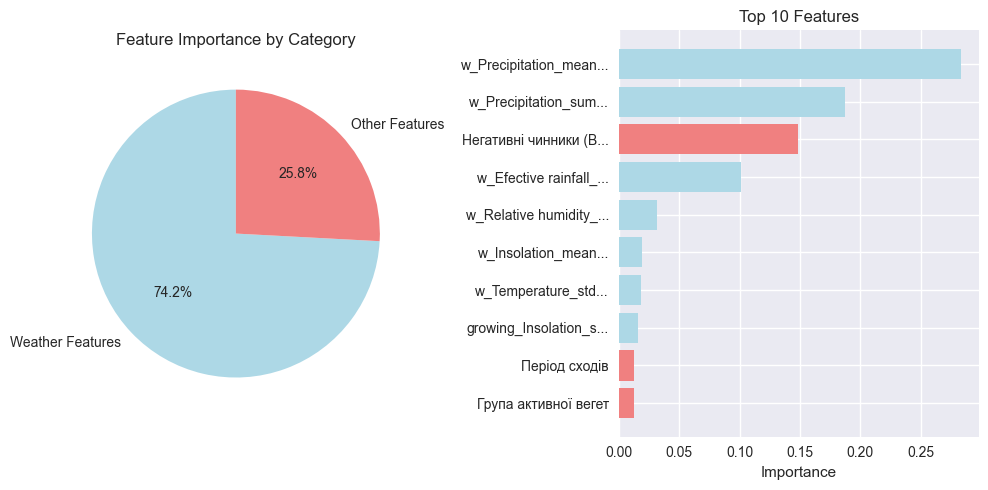

In [12]:
# Create weather vs other features pie chart
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
labels = ['Weather Features', 'Other Features']
sizes = [weather_importance_total, other_importance_total]
colors = ['lightblue', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Feature Importance by Category')

plt.subplot(1, 2, 2)
# Top 10 features bar chart
top_10 = importance_df.head(10)
colors = ['lightblue' if any(w in feat for w in ['weather_', 'growing_', 'critical_', 'early_', 'late_']) 
          else 'lightcoral' for feat in top_10['Feature']]
plt.barh(range(len(top_10)), top_10['Importance'], color=colors)
plt.yticks(range(len(top_10)), [f.replace('weather_', 'w_')[:20] + '...' if len(f) > 20 else f 
                                for f in top_10['Feature']])
plt.xlabel('Importance')
plt.title('Top 10 Features')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [25]:
model_names = list(results.keys())  # ['Conservative', 'Balanced', 'Performance']
models_dict = dict(zip(model_names, models))  # Convert list to dict

best_model_name = max(results.keys(), key=lambda x: results[x]['test_r2'])
best_model = models_dict[best_model_name]
best_result = results[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Detailed Performance Metrics:")
print(f"Test R²: {best_result['test_r2']:.3f}")
print(f"Test RMSE: {best_result['test_rmse']:.2f}")
print(f"CV RMSE: {best_result['cv_rmse']:.2f}")
print(f"Overfitting Gap: {best_result['overfitting']:.2f}")

Best Model: Performance
Detailed Performance Metrics:
Test R²: 0.688
Test RMSE: 6.55
CV RMSE: 13.50
Overfitting Gap: 6.95


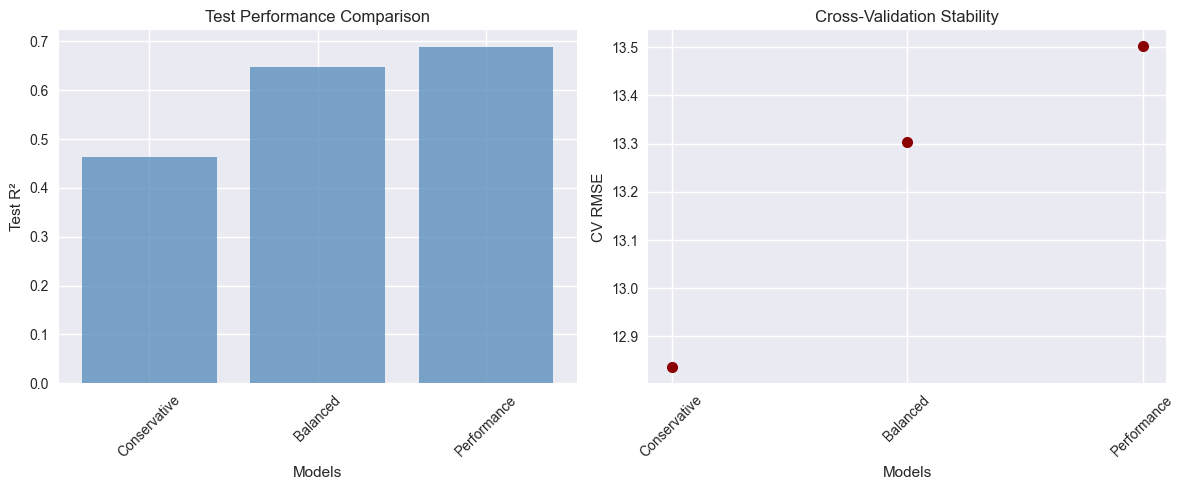

In [19]:
# Cross-validation stability analysis
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
models_list = list(results.keys())
test_r2 = [results[model]['test_r2'] for model in models_list]

x_pos = np.arange(len(models_list))
plt.bar(x_pos, test_r2, alpha=0.7, color='steelblue')
plt.xlabel('Models')
plt.ylabel('Test R²')
plt.title('Test Performance Comparison')
plt.xticks(x_pos, models_list, rotation=45)

plt.subplot(1, 2, 2)
cv_rmse = [results[model]['cv_rmse'] for model in models_list]

# Check if cv_std exists, if not, just plot without error bars
if 'cv_std' in results[models_list[0]]:
    cv_std = [results[model]['cv_std'] for model in models_list]
    plt.errorbar(x_pos, cv_rmse, yerr=cv_std, fmt='o', capsize=5, capthick=2, color='darkred')
else:
    # Plot without error bars if cv_std is not available
    plt.plot(x_pos, cv_rmse, 'o', markersize=8, color='darkred')

plt.xlabel('Models')
plt.ylabel('CV RMSE')
plt.title('Cross-Validation Stability')
plt.xticks(x_pos, models_list, rotation=45)

plt.tight_layout()
plt.show()

In Conclusion, we were able to achieve R^2 = 0.688 with good stability and RMSE = 6.55 tons/hectare prediction error.

We know that effective rainfall is the strongest predictor of the final yield, and it is crucial to further analyse aand study precipitation patterns and weather stress indicators that could bring floods or droughts. 

As for the farming data, we see that negative factors like pests and diseses significantly impact yield and tech adoption of irrigiation and additional protection of the crops have strong impact on the final yield as well. 

For further research, this model could be greatly improved by adding satelite images into the process (this approach is alreaady working in Europe) and collect more pre-harvest soil data. 